## Final Project: Board Game Analysis


The dataset I'll be analyzing contains scraped data from the website BoardGameGeek. The dataset should contain information on the various games that have earned enough user ratings on the website (30+ ratings). I'll be looking into Clustering and looking for any patterns, as well training a model to predict user ratings with the available features.

Source: https://www.kaggle.com/datasets/andrewmvd/board-games

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

### Part 1: Data Importing and EDA

First start by importing the data from the csv.

In [2]:
# Importing the data

df = pd.read_csv('bgg_dataset.csv', sep=';')
print(df.info())
print(df.columns)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB
None
Index(['ID', 'Name', 'Year Published', '

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


There's a few things I note off the bat from looking at the first few rows: 
1. Some of the data types weren't imported right. Complexity Average and Rating Average should be converted to floats, ID, Year Published, and Owned Users to Integers.
2. Mechanics and Domains can contain multiple tags/categories in each column, so I'll need to factor that in somehow.
3. Some degree of scaling might be needed if I'm using any distance based models (Owned Users and Users rated are significantly larger than anything else).

Before I do all that, I want to handle null values first though.

#### Removing NaN values
Looking at the data, there's a lot of games with blank Mechanics and Domains. These should probably still be kept since they're still otherwise valid and it's a pretty big chunk of the data. I'll replace the Nan values later when I split those columns into multi-categories.

I will probably remove the ones with missing IDs and Owned Users data though, since it's a small enough subset to not matter much.

In [3]:
na_count = df.isna().sum()

print(na_count)

ID                       16
Name                      0
Year Published            1
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              23
Mechanics              1598
Domains               10159
dtype: int64


In [4]:
df = df.dropna(subset=['ID', 'Owned Users'])
print(df.isna().sum())

ID                        0
Name                      0
Year Published            0
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users               0
Mechanics              1581
Domains               10136
dtype: int64


#### Converting Data types
Changing column types to int and float as mentioned earlier.

In [5]:
# Changing columns to int
df = df.astype({"Owned Users": int, "Year Published": int, "ID": int})

# Changing decimal strings to floats
df['Rating Average'] = df['Rating Average'].replace(',', '.', regex=True).astype(float)
df['Complexity Average'] = df['Complexity Average'].replace(',', '.', regex=True).astype(float)

df.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430,Gloomhaven,2017,1,4,120,14,42055,8.79,1,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517,Brass: Birmingham,2018,2,4,120,14,19217,8.66,3,3.91,28785,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791,Terraforming Mars,2016,1,5,120,12,64864,8.43,4,3.24,87099,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078,Twilight Imperium: Fourth Edition,2017,3,6,480,14,13468,8.70,5,4.22,16831,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


#### Checking for Dupes
Next, I want to make sure there's no duplicate data. I'm mainly checking the ID, Name, and Year Published columns for this.

In [6]:
print("Duplicate ID count: " + str(df['ID'].duplicated().sum()))
print("Duplicate Name count: " + str(df['Name'].duplicated().sum()))
print("Duplicate Name + Year count: " + str(df.duplicated(subset=['Name', 'Year Published'], keep=False).sum()))

Duplicate ID count: 0
Duplicate Name count: 367
Duplicate Name + Year count: 12


Even though there's quite a few duplicate names (367), I can't discount that there might be multiple board games sharing a name or multiple versions of the same game. So I'll only delete the entries that share both Name and Year. There weren't any duplicate IDs, so I don't need to worry about that.

In [7]:
print(df.shape)
df = df.drop_duplicates(subset=['Name', 'Year Published'])
print(df.shape)

(20320, 14)
(20314, 14)


Now that I've dropped the duplicates, I'll probably drop the ID and Name column as well. It's unlikely to be an important feature for any of the models, and being a non-numeric value might overcomplicate things in the case of Name.

In [8]:
df = df.drop(['ID', 'Name'], axis=1)

#### Handling Mechanic and Domain Columns
This one's a bit trickier to handle. For one, besides the name column they're the only non-numerical columns, so if I want to do something like NMF, I'll either need to cut the columns completely, or convert them to numbers. I also have the option to just remove the columns entirely, but it feels like there's quite a bit of info stored in these columns, so I'd rather not. 

I'll start by getting the # of unique values in Mechanics and Domain (without factoring in combinations).

In [9]:
domain_u = df['Domains'].nunique()
print("Unique Domains: " + str(domain_u))

mech_u = df['Mechanics'].nunique()
print("Unique Mechanics: " + str(mech_u))

Unique Domains: 39
Unique Mechanics: 7377


If the number of unique combinations for Mechanics/Domains was small enough, I considered just ignoring it and just treat combinations as their own unique value, and that might work for the Domains column, but the number of Unique combinations of Mechanics is probably too large to ignore.

As a solution, I'll use the MultiLabelBinarizer from sklearn to apply one-hot encoding, which should change the categories to numerical values, and split each category into its own column. This will increase the dimensionality of the data, but should provide useful information for the models to train on.

In [10]:
# Splitting Domains
df['Domains'] = df['Domains'].fillna('Unknown Domain')
df['Domains'] = df['Domains'].apply(lambda x: [y.strip() for y in str(x).split(',')])
mlb_d = MultiLabelBinarizer()
df_domain_encoded = pd.DataFrame(mlb_d.fit_transform(df['Domains']), columns=mlb_d.classes_, index=df.index)
df = pd.concat([df, df_domain_encoded], axis=1)

df = df.drop('Domains', axis=1)

df.columns

Index(['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age',
       'Users Rated', 'Rating Average', 'BGG Rank', 'Complexity Average',
       'Owned Users', 'Mechanics', 'Abstract Games', 'Children's Games',
       'Customizable Games', 'Family Games', 'Party Games', 'Strategy Games',
       'Thematic Games', 'Unknown Domain', 'Wargames'],
      dtype='object')

In [11]:
# Splitting Mechanics
df['Mechanics'] = df['Mechanics'].fillna('Unknown Mechanic')
df['Mechanics'] = df['Mechanics'].apply(lambda x: [y.strip() for y in str(x).split(',')])
mlb_m = MultiLabelBinarizer()
df_mechanic_encoded = pd.DataFrame(mlb_m.fit_transform(df['Mechanics']), columns=mlb_m.classes_, index=df.index)
df = pd.concat([df, df_mechanic_encoded], axis=1)

df = df.drop('Mechanics', axis=1)

df.columns

Index(['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age',
       'Users Rated', 'Rating Average', 'BGG Rank', 'Complexity Average',
       'Owned Users',
       ...
       'Turn Order: Stat-Based', 'Unknown Mechanic', 'Variable Phase Order',
       'Variable Player Powers', 'Variable Set-up',
       'Victory Points as a Resource', 'Voting', 'Worker Placement',
       'Worker Placement with Dice Workers', 'Zone of Control'],
      dtype='object', length=202)

In [12]:
print("Total Mechanics: " + str(len(mlb_m.classes_)))
print("Total Domains: " + str(len(mlb_d.classes_)))

Total Mechanics: 183
Total Domains: 9


#### Plotting out Histograms for Mechanics and Domains
Just looking at the overall distribution of Mechanics and Domains. Note that there's some overlap since a game can have multiple mechanics/domains.

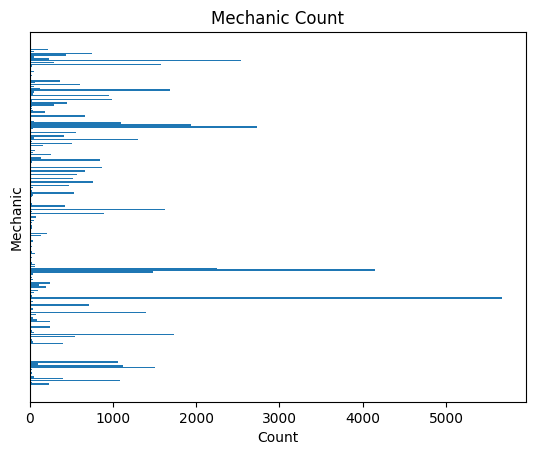

In [13]:
mechanic_sum = df[mlb_m.classes_].sum()

plt.barh(mechanic_sum.index, mechanic_sum)
plt.title('Mechanic Count')
plt.xlabel('Count')
plt.ylabel('Mechanic')
plt.yticks([])

plt.show()

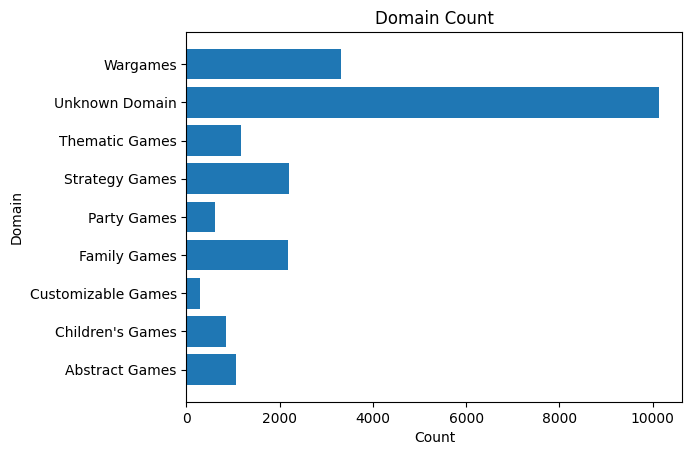

In [14]:
domain_sum = df[mlb_d.classes_].sum()

plt.barh(domain_sum.index, domain_sum)
plt.title('Domain Count')
plt.xlabel('Count')
plt.ylabel('Domain')

plt.show()

I'm a little concerned that the Unknown Domain (the NaN replacement value) might skew the data as an outlier, but it's a bit awkward to cut too, so I'll leave it in and see how it affects things.

#### Score Distribution
I also want to see how scores are distributed on average. It seems like a bell curve with most scores situated between 6-7.

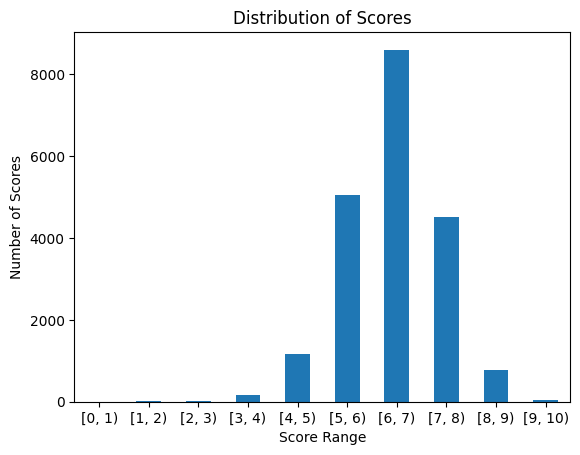

In [15]:
bins = range(0, 11)
rate_range = pd.cut(df['Rating Average'], bins=bins, right=False)

score_counts = rate_range.value_counts().sort_index()

score_counts.plot(kind='bar')
plt.title('Distribution of Scores')
plt.xlabel('Score Range')
plt.ylabel('Number of Scores')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

#### Other Columns
Drawing Box Plots for the other columns I haven't checked yet. 

Most of them have fairly narrow ranges, but there's some values that are outside the expected range in a few columns (like 999 max players, or the 60000 playtime). 

With that said, I believe the values are legitimate, and not errors or mislabels, so I think in this case it makes more sense not to remove them. With the amount of features available, I don't think any of these columns will have enough weight where these few exceptions will skew the data too much, especially after scaling.

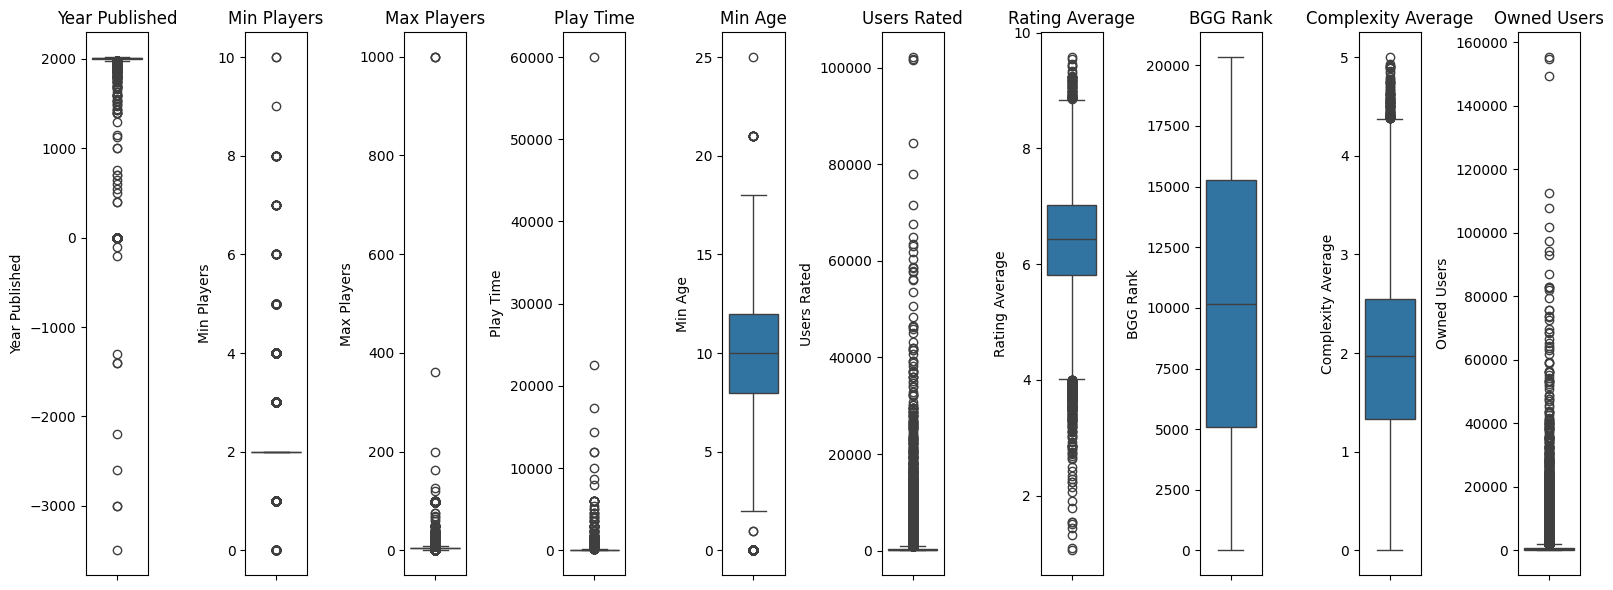

In [16]:
col_names = ['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank', 'Complexity Average', 'Owned Users']

fig, axes = plt.subplots(1, len(col_names), figsize=(16, 6))

for i, column in enumerate(col_names):
    sns.boxplot(y=df[column], ax=axes[i])  # Plot on each axis
    axes[i].set_title(column)  # Set title as the column name

plt.tight_layout()
plt.show()

In [17]:
def check_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the rows where the column value is outside the bounds
        print(df[columns] >= upper_bound)
        in_range = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        out_range = df[(df[column] <= lower_bound) & (df[column] >= upper_bound)]

    return out_range

print(np.unique(df['Max Players']))
check_outliers_iqr(df, ['Max Players']).head()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  20  21  22  23  24  25  26  28  30  31  32  33  34  36  38  40  41
  42  45  48  50  52  60  64  68  69  75  99 100 120 127 163 200 362 999]
       Max Players
0            False
1            False
2            False
3            False
4            False
...            ...
20338        False
20339         True
20340        False
20341        False
20342        False

[20314 rows x 1 columns]


,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,...,Turn Order: Stat-Based,Unknown Mechanic,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control


#### Scaling Data
Since some of the models like NMF will want the data scaled first since they're sensitive to magnitude differences between features.
Don't want to scale the rating though?

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

print(scaled_df[:5])

[[0.99909453 0.1        0.004004   ... 0.         0.         0.        ]
 [0.99873234 0.2        0.004004   ... 0.         0.         0.        ]
 [0.99927562 0.2        0.004004   ... 0.         0.         0.        ]
 [0.99891344 0.1        0.00500501 ... 0.         0.         0.        ]
 [0.99909453 0.3        0.00600601 ... 0.         0.         0.        ]]


### Part 2: Unsupervised Learning using NMF
After splitting the Mechanic and Domain columns, all columns are now numerical (besides Name, which can probably just be dropped), so we can try using Non-negative Matrix Factorization (NMF) to create a model and see how well it can predict missing user ratings.

There's not really a goal in terms of how many components I'm expecting, so I might tune that as the main hyperparameter. I'll be using the default nndsvd as the init value since I have dense starting data. Will probably stick with Coordinate Descent as the solver as well since it's a dense matrix.

#### NMF 1:
Starting with n_components = 3 as a baseline.

In [19]:
# Storing scores for later
nmf_stats = {}

In [20]:
nmf_model = NMF(n_components=3, init='nndsvd', random_state=42, max_iter=500)
W_rand = nmf_model.fit_transform(scaled_df)
H_rand = nmf_model.components_

prediction = np.dot(W_rand, H_rand)

# Need to revert scaling to get score
predict_df = pd.DataFrame(scaler.inverse_transform(prediction), columns=df.columns)

print(predict_df.head()['Rating Average'])
print(df.head()['Rating Average'])

0    9.750426
1    9.003506
2    7.484653
3    9.326766
4    9.149272
Name: Rating Average, dtype: float64
0    8.79
1    8.61
2    8.66
3    8.43
4    8.70
Name: Rating Average, dtype: float64


#### NMF 1 Results:
Taking a look at common regression stats (MSE, RMSE, MAE, and R-squared).

In [21]:
def reg_stats(actual_values, predicted_values):
    # Calculate regression metrics
    stats = {}
    stats['mse'] = mean_squared_error(actual_values, predicted_values)
    stats['rmse'] = np.sqrt(stats['mse'])
    stats['mae'] = mean_absolute_error(actual_values, predicted_values)
    stats['r2'] = r2_score(actual_values, predicted_values)

    print(f"Mean Squared Error (MSE): {round(stats['mse'], 5)}")
    print(f"Root Mean Squared Error (RMSE): {round(stats['rmse'], 5)}")
    print(f"Mean Absolute Error (MAE): {round(stats['mae'], 5)}")
    print(f"R-squared: {round(stats['r2'], 5)}")

    return stats

nmf_stats[3] = reg_stats(df['Rating Average'], predict_df['Rating Average'])


Mean Squared Error (MSE): 0.90491
Root Mean Squared Error (RMSE): 0.95127
Mean Absolute Error (MAE): 0.7583
R-squared: -0.03408


Overall, looks very bad. The errors don't look terrible until you realize most scores are between 6 and 8, so being off by almost 1 is pretty far off, and the R-squared being in the negative is a pretty clear indicator that isn't a great fit. 

#### NMF Part 2: 
Trying different n_component values [5, 10, 20, 30, 50, 60, 70, 80, 100].

In [350]:
n_components = [5, 10, 20, 30, 50, 60, 70, 80, 100]

for n in n_components:
    nmf_model = NMF(n_components=n, init='nndsvd', random_state=42, max_iter=500)
    W_rand = nmf_model.fit_transform(scaled_df)
    H_rand = nmf_model.components_

    prediction = np.dot(W_rand, H_rand)

    # Need to revert scaling to get score
    predict_df = pd.DataFrame(scaler.inverse_transform(prediction), columns=df.columns)

    print("For n_components = : " + str(n))
    nmf_stats[n] = reg_stats(df['Rating Average'], predict_df['Rating Average'])

For n_components = : 5
Mean Squared Error (MSE): 0.81865
Root Mean Squared Error (RMSE): 0.90479
Mean Absolute Error (MAE): 0.71709
R-squared: 0.06449
For n_components = : 10
Mean Squared Error (MSE): 0.75927
Root Mean Squared Error (RMSE): 0.87136
Mean Absolute Error (MAE): 0.68367
R-squared: 0.13235
For n_components = : 20
Mean Squared Error (MSE): 0.64068
Root Mean Squared Error (RMSE): 0.80042
Mean Absolute Error (MAE): 0.62298
R-squared: 0.26787
For n_components = : 30
Mean Squared Error (MSE): 0.41336
Root Mean Squared Error (RMSE): 0.64293
Mean Absolute Error (MAE): 0.48604
R-squared: 0.52764
For n_components = : 50
Mean Squared Error (MSE): 0.23617
Root Mean Squared Error (RMSE): 0.48597
Mean Absolute Error (MAE): 0.36054
R-squared: 0.73012
For n_components = : 60
Mean Squared Error (MSE): 0.18584
Root Mean Squared Error (RMSE): 0.43109
Mean Absolute Error (MAE): 0.31385
R-squared: 0.78764
For n_components = : 70
Mean Squared Error (MSE): 0.12687
Root Mean Squared Error (RMSE):

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


For n_components = : 80
Mean Squared Error (MSE): 0.00138
Root Mean Squared Error (RMSE): 0.03717
Mean Absolute Error (MAE): 0.00557
R-squared: 0.99842
For n_components = : 100
Mean Squared Error (MSE): 0.00118
Root Mean Squared Error (RMSE): 0.0343
Mean Absolute Error (MAE): 0.00224
R-squared: 0.99866


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


The computation starts slowing down a lot at n_components >= 80, so I'll cut off the testing there, but there's a noticeable increase in accuracy as the number of components goes up. I also hit the warning for max iterations at 80/100, so in theory, the accuracy could go even higher, but that's likely approaching the point of overfitting. At least based on the points I tested, the ideal number of components is likely between 70 and 80, since that seems to be the inflection point where accuracy gains start to be less noticeable.

#### Visualizations

[np.float64(0.9512653312964782), np.float64(0.9047926901858511), np.float64(0.8713593588054724), np.float64(0.8004223074343612), np.float64(0.6429277066070569), np.float64(0.4859716275883302), np.float64(0.43108779807116576), np.float64(0.35619234749942), np.float64(0.03716540953626955), np.float64(0.03430487482287601)]


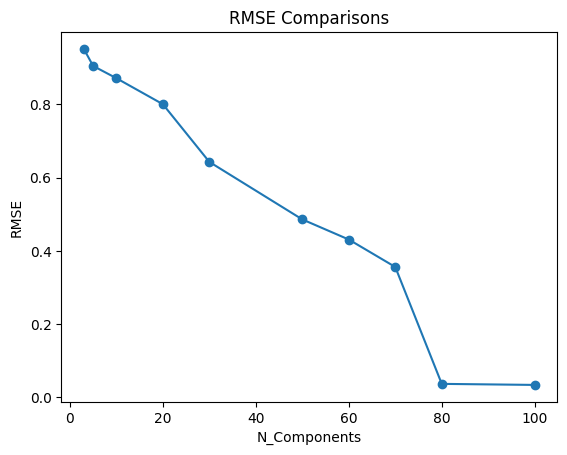

In [354]:
# R-squared Plot
x_values = list(nmf_stats.keys())
y_values = [v['rmse'] for v in nmf_stats.values()]

print(y_values)

# Create the line graph
plt.plot(x_values, y_values, marker='o')  

# Add labels and title
plt.xlabel('N_Components')
plt.ylabel('RMSE')
plt.title('RMSE Comparisons')

# Display the graph
plt.show()

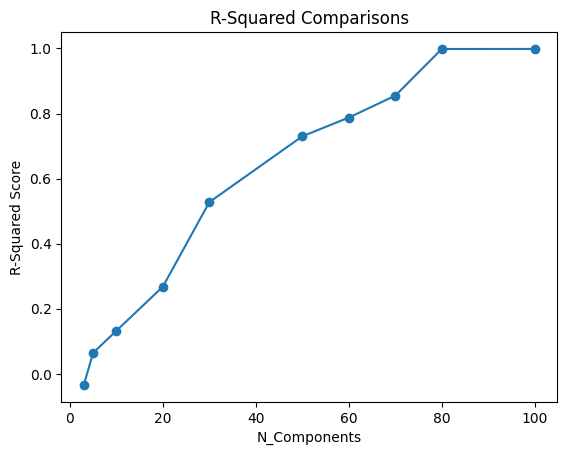

In [355]:
# R-squared Plot
x_values = list(nmf_stats.keys())
y_values = [v['r2'] for v in nmf_stats.values()]

# Create the line graph
plt.plot(x_values, y_values, marker='o')  

# Add labels and title
plt.xlabel('N_Components')
plt.ylabel('R-Squared Score')
plt.title('R-Squared Comparisons')

# Display the graph
plt.show()

### Part 3: Trying Supervised Learning
When we include the Domains and Mechanics columns (split into multiple columns), we have a relatively high number of features in this data set. Since we're trying to predict the Average Rating, we'll need to use regression models, so I'll be testing with Linear Regression and SVM.

Unlike Unsupervised, I actually need to split the data first into training/test splits since it'll overfit otherwise.

In [30]:
from sklearn.model_selection import train_test_split
X = df.drop(['Rating Average'], axis=1)
y = df['Rating Average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
print(y_train.shape)

(14219,)


#### Supervised 1: Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

lr_clf = LinearRegression().fit(X_train, y_train)

print("Linear Regression Training Score: " + str(lr_clf.score(X_train, y_train)))
print("Linear Regression Test Score: " + str(lr_clf.score(X_test, y_test)))

Linear Regression Training Score: 0.6794127261999352
Linear Regression Test Score: 0.6601754874213521


In [32]:
reg_stats(y_test, lr_clf.predict(X_test))

Mean Squared Error (MSE): 0.29516
Root Mean Squared Error (RMSE): 0.54329
Mean Absolute Error (MAE): 0.40016
R-squared: 0.66018


{'mse': np.float64(0.295162862791762),
 'rmse': np.float64(0.5432889312251465),
 'mae': np.float64(0.40015845238439685),
 'r2': 0.6601754874213521}

Not an amazing score overall, but it's not terrible either. The average error isn't too high, and .66 R-squared isn't great but at least shows there's somewhat of a fit still. Hopefully it can be improved though.

#### Supervised 2: Support Machine Vectors (SVM/SVR)
We can try using SVMs as another Regression Model to test with. I'll try out a few kernels and C values to see which hyperparameters work.

Note: Linear kernel was causing issues on my computer for some reason, so only testing poly and rbf. I don't think linear would be the best kernel anyways.

In [33]:
from sklearn.svm import SVR

kernels = ['rbf', 'poly']
Cs = [0.1, 1, 10, 100]
svm_stats = {}

for k in kernels:
    for C_val in Cs:
        svr_model = SVR(kernel=k, C=C_val)
        svr_model.fit(X_train, y_train)

        print("---")
        print("For Kernel " + str(k) + " and C value " + str(C_val))
        svm_stats[(k, C_val)] = reg_stats(y_test, svr_model.predict(X_test))
        print("Linear Regression Training Score: " + str(svr_model.score(X_train, y_train)))
        print("Linear Regression Test Score: " + str(svr_model.score(X_test, y_test)))

---
For Kernel rbf and C value 0.1
Mean Squared Error (MSE): 0.23587
Root Mean Squared Error (RMSE): 0.48567
Mean Absolute Error (MAE): 0.3368
R-squared: 0.72844
Linear Regression Training Score: 0.7339360942504829
Linear Regression Test Score: 0.7284355156520865
---
For Kernel rbf and C value 1
Mean Squared Error (MSE): 0.19657
Root Mean Squared Error (RMSE): 0.44336
Mean Absolute Error (MAE): 0.29513
R-squared: 0.77369
Linear Regression Training Score: 0.7792344176694458
Linear Regression Test Score: 0.7736905085724435
---
For Kernel rbf and C value 10
Mean Squared Error (MSE): 0.16937
Root Mean Squared Error (RMSE): 0.41154
Mean Absolute Error (MAE): 0.26686
R-squared: 0.805
Linear Regression Training Score: 0.8089628884791771
Linear Regression Test Score: 0.8050040900591708
---
For Kernel rbf and C value 100
Mean Squared Error (MSE): 0.15188
Root Mean Squared Error (RMSE): 0.38972
Mean Absolute Error (MAE): 0.24626
R-squared: 0.82514
Linear Regression Training Score: 0.835182714765

Conclusions: Performs better than Linear Regression, but still not amazing. The poly kernel did not perform very well (Maxing out at around a .66 R Squared score before presumably overfitting). The radial kernel performs much better with the .819 score at C=100, but it's still noticeably worse 

### Part 4: PCA + Supervised
Since we have a wide number of features, we can potentially try dimensionality reduction with PCA and feed that into LR and SVM to see how that performs. I'll try with different numer of n_components for PCA as the hyperparameter to see if it helps with the regression models.

In [82]:
# Helper for running PCA
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

def run_pca(n_comp):
    #Scaling first
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)

    return train_test_split(X_pca, y_scaled, test_size=0.3, random_state=0)


In [83]:
# Helper, runs Linear Regression
def lr_pca(X_trainp, X_testp, y_trainp, y_testp):
    lrp_clf = LinearRegression().fit(X_trainp, y_trainp)

    y_testp_pred_scaled = lrp_clf.predict(X_testp)

    y_testp_pred = scaler_y.inverse_transform(y_testp_pred_scaled.reshape(-1, 1)).flatten()
    y_testp_orig = scaler_y.inverse_transform(y_testp.reshape(-1, 1)).flatten()

    reg_stats(y_testp_orig, y_testp_pred)

In [84]:
# Helper, runs SVR model
def svr_pca(X_trainp, X_testp, y_trainp, y_testp):
    svr_modelp = SVR(kernel='rbf', C=100) 
    svr_modelp.fit(X_trainp, y_trainp)

    y_testp_pred_scaled = svr_modelp.predict(X_testp)

    y_testp_pred = scaler_y.inverse_transform(y_testp_pred_scaled.reshape(-1, 1)).flatten()
    y_testp_orig = scaler_y.inverse_transform(y_testp.reshape(-1, 1)).flatten()

    reg_stats(y_testp_orig, y_testp_pred)

In [85]:
n_components_2 = [2, 5, 10, 20, 30, 50, 60, 70, 80, 100]
for n in n_components_2:
    X_trainp, X_testp, y_trainp, y_testp = run_pca(n)
    print("")
    print("Linear Regression with n = " + str(n))
    lr_pca(X_trainp, X_testp, y_trainp, y_testp)

    print("")
    print("SVR with n = " + str(n))
    svr_pca(X_trainp, X_testp, y_trainp, y_testp)


Linear Regression with n = 2
Mean Squared Error (MSE): 0.72127
Root Mean Squared Error (RMSE): 0.84927
Mean Absolute Error (MAE): 0.65547
R-squared: 0.15949

SVR with n = 2
Mean Squared Error (MSE): 0.45175
Root Mean Squared Error (RMSE): 0.67213
Mean Absolute Error (MAE): 0.51184
R-squared: 0.47356

Linear Regression with n = 5
Mean Squared Error (MSE): 0.62008
Root Mean Squared Error (RMSE): 0.78745
Mean Absolute Error (MAE): 0.60203
R-squared: 0.2774

SVR with n = 5
Mean Squared Error (MSE): 0.36284
Root Mean Squared Error (RMSE): 0.60236
Mean Absolute Error (MAE): 0.46203
R-squared: 0.57717

Linear Regression with n = 10
Mean Squared Error (MSE): 0.47515
Root Mean Squared Error (RMSE): 0.68931
Mean Absolute Error (MAE): 0.52269
R-squared: 0.4463

SVR with n = 10
Mean Squared Error (MSE): 0.36681
Root Mean Squared Error (RMSE): 0.60564
Mean Absolute Error (MAE): 0.45979
R-squared: 0.57255

Linear Regression with n = 20
Mean Squared Error (MSE): 0.41854
Root Mean Squared Error (RMSE

Somewhat surprisingly, PCA didn't really accomplish much. I was hoping that by reducing the dimensionality of the matrix, the regression models would perform better, but in reality, it was only a minor increase in score for Linear Regression, and the SVM actually got significantly worse (never getting past a 0.64 score). This likely means the original data doesn't have an abundance of noise that needed to be cut out by PCA, or perhaps the dimension count wasn't high enough to warrant the use of PCA.

PCA also does somewhat assume linear relationships, so it's possible that was the issue as well.

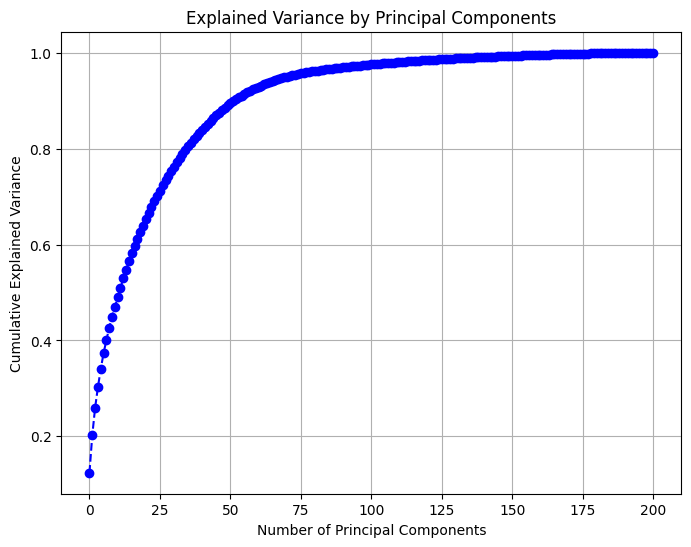

In [87]:
pca_g = PCA().fit(scaler_x.fit_transform(X))

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_g.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

I wanted to verify the n_component numbers I was testing PCA with made sense, so I mapped out the above. It seems to line up the results from testing with LR and SVM, most of the variance is explained by around 50 and it's not much of an increase past that.

### Part 5: Conclusions

#### Summary Table:

|Method|RMSE|R-Squared|
|:----|:--------:|:--------:|
|NMF 3| 0.95127 | -0.03408 |
|NMF 5| 0.90479 | 0.06449 |
|NMF 10|  0.87136 | 0.13235 |
|NMF 20|  0.64067 | 0.26787 |
|NMF 30| 0.64293 | 0.52764 |
|NMF 50| 0.48597 | 0.73012 |
|NMF 70| 0.35619 | 0.85502 |
|NMF 80| 0.03716 | 0.99842 |
|NMF 100| 0.034305 | 0.99866 |
|Linear Regression|  0.54329 | 0.66018 |
|SVM (RBF, C=100)| 0.38972 | 0.82514 |
|SVM (Poly, C=1)| 0.53878 | 0.66579 |
|PCA(n=100) + Linear Regression|  0.56185 | 0.67049 |
|PCA(n=60) + SVM (RBF, C=100)| 0.56743 | 0.62479 |

#### Overall Thoughts:
Overall, it seems like just using the Non-negative Matrix Factorization performed the best out of the attempted methods in terms of predicting user rating averages, with the highest scores by a fairly large margin. The one downside is that it was by far the slowest to calculate as well (at high component counts, NMF could take a few minutes to calculate). So while it performs very well, with significantly larger datasets it might not be feasible.

SVM with Radial kernel and C=100 is probably the next best with the 0.825 R-squared score. Not an amazing score, but it calculates very fast relative to NMF, so it's still a reasonable alternative.



#### Potential Issues/Improvements:
My decision to leave in outliers is probably the most obvious issue. While this probably didn't affect the unsupervised models as much, it likely made a much larger difference when testing with the supervised models.

Given that Linear Regression and using PCA didn't work too well, the data likely doesn't contain too much linearity. This is probably something I should've checked for during the EDA stage, so that might've been an oversight (although it probably would've been worth testing regardless).